# CS216 : Assignment 3

Reading: Boykov & Jolly, ICCV 2001

For written problems, you can either use Markdown/LaTeX to directly enter your reponse in the provided notebook cell, or if you prefer, write out by hand and embed a photo of your solution. For coding problems, I have provided some suggestion of how to structure your code but feel free to modify or ignore as you see fit.

For this assignment we will use the PyMaxflow package.  You can install it from the commandline via "pip install pymaxflow"

Please edit the cell below to include your name and student ID #

---

**name:** Fu-Cheng Hsieh

**SID:** 55284118

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import ndimage
import maxflow
from scipy.cluster.vq import kmeans as kmeans
from selectpoints import select_k_points as select_k_points
plt.rcParams.update({'axes.titlesize': 16})
conv = ndimage.convolve
%matplotlib inline

## 1. Color Quantization

k-means clustering can be used to reduce the color
palette of an image.  Write a function that takes a color image and a value for
$k$ and returns a new version of the image which uses only $k$ distinct colors.
Your code should cluster the pixel color values using k-means and then produce
a new image where each pixel is replaced with the color of the closest cluster center.

You are welcome to use the **kmeans** function provided by **scipy**.
Demonstrate your code on the provided "*rainbow*" image for different values of $k =
{2,5,10}$.  Describe how the clustering changes if you scale one of the feature
coordinates, say the $R$ (red) value by a factor of $1000$?  Specifically, you can test this
by first multiplying the $R$ channel by 1000 and performing the clustering and
then dividing the R channel in the resulting quantized image by 1000 prior to
displaying it.


In [2]:
import cv2
def read_img(file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(float)
    img = img / 255.
    return img

In [3]:
# get clustering result of different k
def cluster(img, k):
    # flatten the image to 2d array (h*w, rgb)
    h, w, channel = img.shape
    img = img.reshape((h*w, channel))
    
    # perform kmeans clustering
    km = kmeans(img, k_or_guess=k)
    
    # calculate the distance between each centroid and pixel and save into dist_map
    centroids, _ = km
    dist_map = []
    for c in centroids:
        c_mat = np.tile([c], (img.shape[0], 1))
        dist = np.sum((img - c_mat) ** 2, axis=1) # calculate the euclidean distance
        dist_map.append(list(dist))
    dist_map = np.array(dist_map)
    
    # get clustering result (which is the nearest centroid for each pixel)
    cluster_res = np.argmin(dist_map, axis=0)
    
    # Assign cluster with color of assigned centroid
    colored_cluster_res = []
    for i, res in enumerate(cluster_res):
        colored_cluster_res.append(centroids[res])
    colored_cluster_res = np.array(colored_cluster_res).reshape((h, w, channel))
    
    return cluster_res, colored_cluster_res

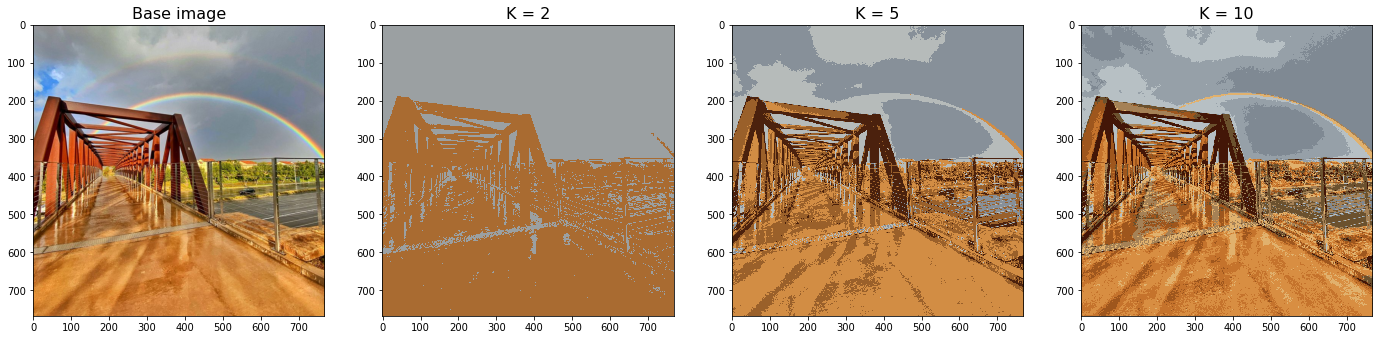

In [4]:
# code
rainbow = read_img("./rainbow_bridge.jpeg")

fig, ax = plt.subplots(1, 4, figsize=(24, 10))
ax[0].imshow(rainbow)
ax[0].set_title("Base image")
i = 1
for k in [2, 5, 10]:
    cluster_res, color_res = cluster(rainbow, k)
    ax[i].imshow(color_res, interpolation="none")
    ax[i].set_title("K = %d" % k)
    i += 1


In the original image, most color seems to be brown (the bridge) and gray (the sky). In k = 2, we can easily see that the Kmeans clustering nicely separates the bridge and background. By increasing the number of clusters, in k = 10, we can see that the rainbow seems to be classified as a distinct cluster since there are more choices of centroid and corresponding RGBs, so the rainbow is now more likely to be distinguished from the background (comparing to k = 2).

In [5]:
def min_max_scale(img):
    if img.max() == img.min():
        return (img - img.min()) / (img.max() - img.min() + 1e-2)
    return (img - img.min()) / (img.max() - img.min())

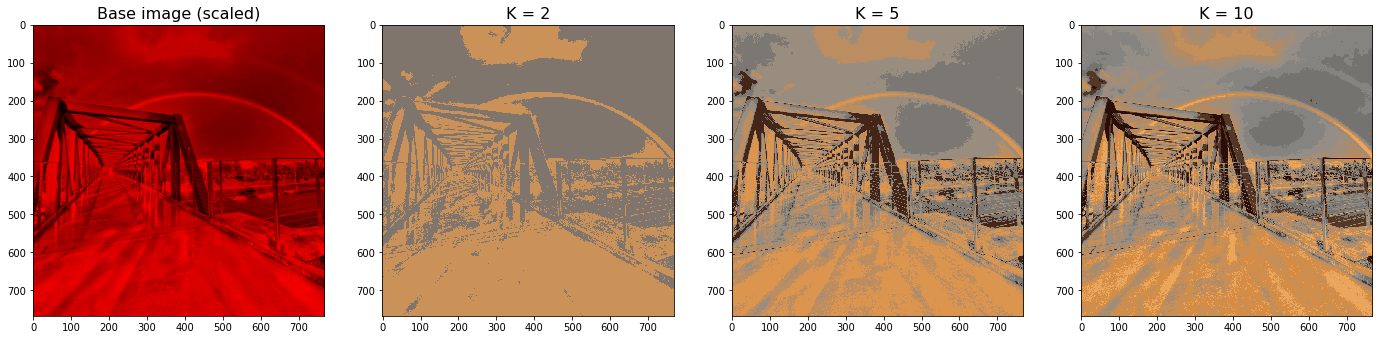

In [6]:
# Scaling R by a factor of 1000
scaled_r_rainbow = np.copy(rainbow)
scaled_r_rainbow[:, :, 0] *= 1000

fig, ax = plt.subplots(1, 4, figsize=(24, 10))
ax[0].imshow(min_max_scale(scaled_r_rainbow))
ax[0].set_title("Base image (scaled)")
i = 1
for k in [2, 5, 10]:
    cluster_res, color_res = cluster(scaled_r_rainbow, k)
    # divide r channel by 1000
    color_res[:, :, 0] /= 1000
    ax[i].imshow(color_res, interpolation="none")
    ax[i].set_title("K = %d" % k)
    i += 1

In the image where R is scaled by a factor of 1000, looking at the base image, we can see that the image seems to be all in red. In the prediction results with k = 2, 5, 10, we can see that since red is the dominant color, most pixels that are initially in different colors are more likely to be in the same group.

## 2. Texture Modeling

## 2.1 Filterbank

In order to analyze texture, we would like to describe the
image in terms of distributions of filter outputs.  Implement a filter bank
function which takes an image as input and filters the image with Gaussian
derivatives in the horizontal and vertical directions at 3 different scales
${\sigma = 1,2,4}$.  Also create an additional center surround filter by taking
the different of two isotropic Gaussian functions at two different scales, e.g.
$G_2(x,y)-G_1(x,y)$ and $G_4(x,y) - G_2(x,y)$.

Your filterbank function should take as input one grayscale image and return 8
filter response images.

### Implementation

In [7]:
def gaussian(sigma, size):
    y, x = np.mgrid[-size:size+1, -size:size+1]
    g = 1 / (2. * np.pi * sigma**2) * np.exp(-(x**2 + y**2) / (2. * sigma**2))
    return g

def gaussian_derivative(sigma):
    size = np.ceil(4. * sigma)
    y, x = np.mgrid[-size:size+1, -size:size+1]
    g = gaussian(sigma, size)
    dx = - x * g / sigma**2
    dy = - y * g / sigma**2
    return conv(dx, g), conv(g, dy)

In [8]:
def filters():
    filters = []
    for sigma in [1, 2, 4]:
        fx, fy = gaussian_derivative(sigma)
        filters.extend([fx, fy])
    size = np.ceil(4.* 4)
    g1 = gaussian(1, size)
    g2 = gaussian(2, size)
    g4 = gaussian(4, size)
    filters.append(g2 - g1)
    filters.append(g4 - g2)
    return filters

def filterbank(img):
    results = []
    for f in filters():
        results.append(conv(img, f))
    return results

### Visualization

Visualize the kernels of your 8 filters as images using a pseudocolor colormap.  

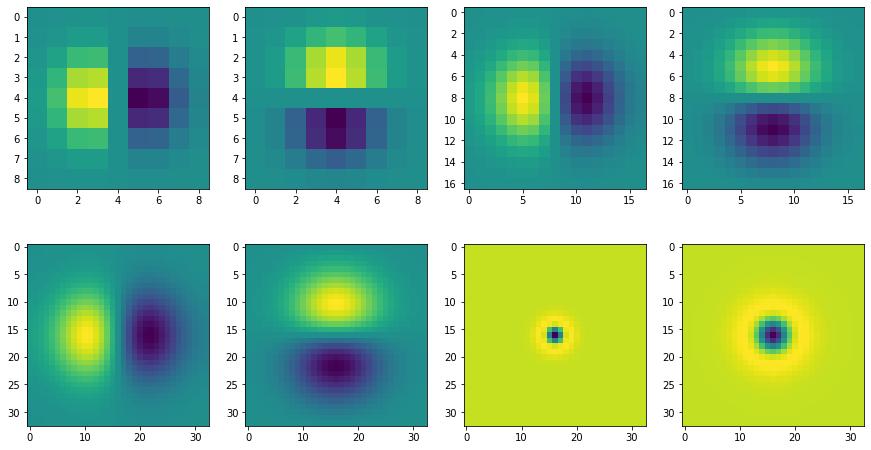

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
i, j = 0, 0

for f in filters():
    ax[i][j].imshow(f)
    j += 1
    if j == 4:
        j = 0
        i += 1

### Filter Statistics

Apply your filter bank to a test image of your choice.  Plot a histogram of each of the individual filter responses on a semi-log plot (i.e., where the x-axis is the value of the filter response and the y-axis is the *log* of the number of pixels that took on that value).  You can use **np.histogram** to compute the histograms and plot them all on the same axis. Choose the number and range of bins which gives a nice smooth, high-res curve. How do they compare to the distributions shown in the lecture 8 slides?

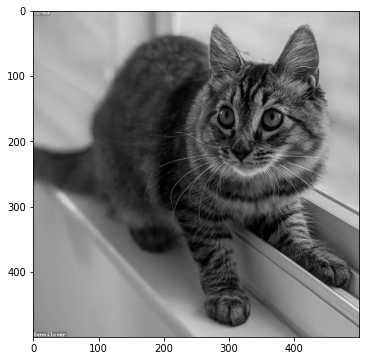

In [10]:
# read cat image
cat = cv2.imread("./cat.jpg")
# convert image to grayscale
cat = min_max_scale(cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY))
plt.figure(figsize=(6,6))
plt.imshow(cat, "gray")
plt.show()

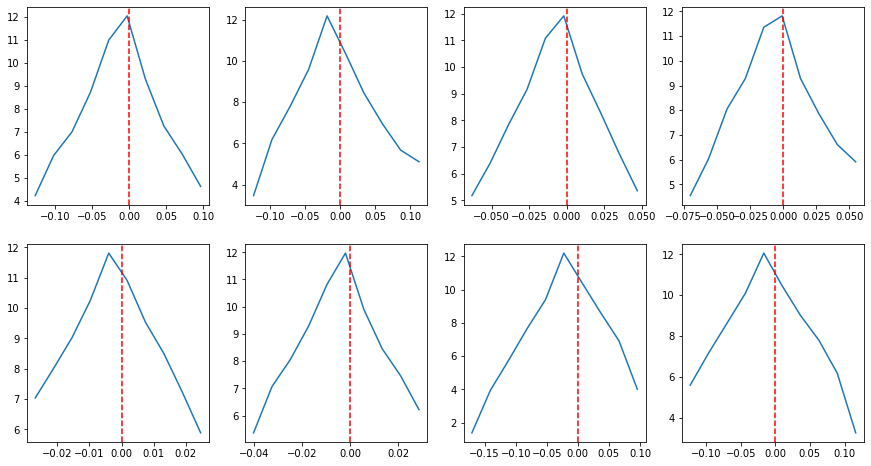

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))

resps = filterbank(cat)
i, j = 0, 0
for r in resps:
    hist, bins = np.histogram(r)
    ax[i][j].plot(bins[:-1], np.log(hist))
    ax[i][j].axvline(x=0, c='red', linestyle='--')
    j += 1
    if j == 4:
        i += 1
        j = 0
plt.show()

In the graphs shown above, x is the value of responses, and y is the count of each bin (in log scale). By looking at the histograms of response, we can see that they are similar to the figure in lecture 8, in which we have a peak number of y near x = 0.

## 2.2 Texture Analysis

Convince yourself that the distribution of filter outputs really captures
something about the texture.  You can use the **zebra_small.jpg** image.

Select a image patch (say 40x40 pixels) over the zebra's neck and compute the
mean absolute response of each of the 8 filter responses over that region 
(if you don't take an absolute value then the positive and negative
components will tend to cancel out and give you mean 0). This will give you a vector
of 8 numbers that summarize the patch texture. Compute the mean
absolute responses of the filterbank channels for similar regions in the tree
leaves above the zebra's back and also on the grass in front of the zebra.

Visualize (e.g., using the **plt.bar** function) the three mean
response vectors for these regions and explain the differences you see in terms
of your filters.  

Important Note: you may need to experiment with resizing
image to find the best scale at which to capture the texture. In your writeup,
explain how you chose the scale.

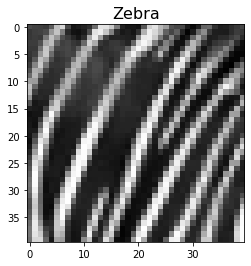

In [12]:
zebra_neck = cv2.imread("./zebra_neck.jpg")
zebra_neck = min_max_scale(cv2.cvtColor(zebra_neck, cv2.COLOR_BGR2GRAY))
plt.figure(figsize=(4,4))
plt.title("Zebra")
plt.imshow(zebra_neck, "gray")
plt.show()

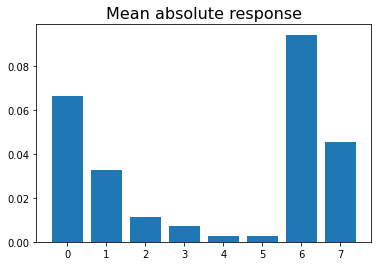

In [13]:
resps = np.array(filterbank(zebra_neck))
zebra_mean_abs_resp = [np.mean(abs(r)) for r in resps]
plt.bar(np.arange(8), zebra_mean_abs_resp)
plt.title("Mean absolute response")
plt.show()

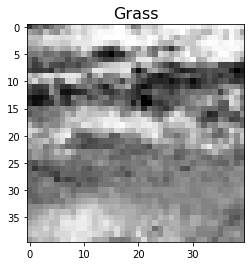

In [14]:
grass = cv2.imread("./grass.jpg")
grass = min_max_scale(cv2.cvtColor(grass, cv2.COLOR_BGR2GRAY))
plt.figure(figsize=(4,4))
plt.imshow(grass, "gray")
plt.title("Grass")
plt.show()

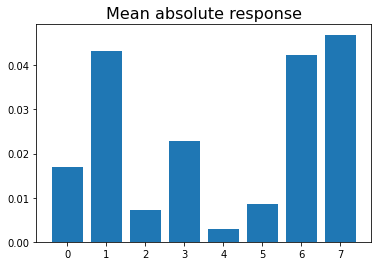

In [15]:
resps = np.array(filterbank(grass))
grass_mean_abs_resp = [np.mean(abs(r)) for r in resps]
plt.bar(np.arange(8), grass_mean_abs_resp)
plt.title("Mean absolute response")
plt.show()

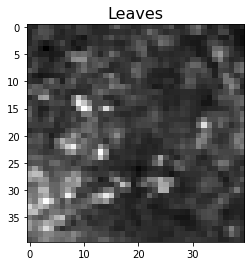

In [16]:
leaves = cv2.imread("./leaves.jpg")
leaves = min_max_scale(cv2.cvtColor(leaves, cv2.COLOR_BGR2GRAY))
plt.figure(figsize=(4,4))
plt.title("Leaves")
plt.imshow(leaves, "gray")
plt.show()

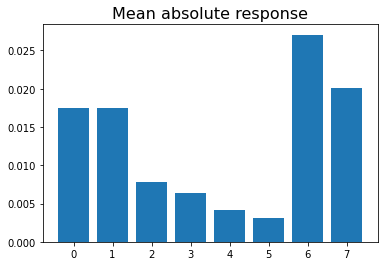

In [17]:
resps = np.array(filterbank(leaves))
leaves_mean_abs_resp = [np.mean(abs(r)) for r in resps]
plt.bar(np.arange(8), leaves_mean_abs_resp)
plt.title("Mean absolute response")
plt.show()

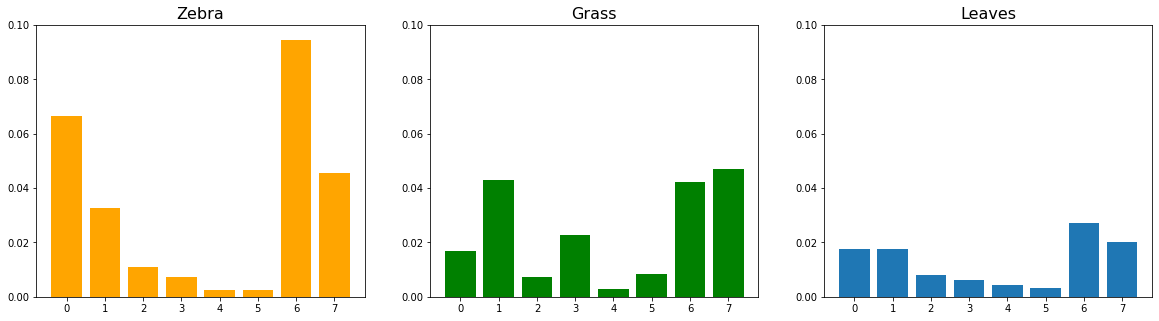

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].bar(np.arange(8), zebra_mean_abs_resp, color="orange")
ax[0].set_title("Zebra")
ax[0].set_ylim(0, 0.1)
ax[1].bar(np.arange(8), grass_mean_abs_resp, color="green")
ax[1].set_title("Grass")
ax[1].set_ylim(0, 0.1)
ax[2].bar(np.arange(8), leaves_mean_abs_resp, label="leaves")
ax[2].set_title("Leaves")
ax[2].set_ylim(0, 0.1)
plt.show()

By comparing the distribution of mean absolute responses, we can easily see that the three distributions differ from each other. 
I didn't rescale the image since the results seem pretty good. However, rescaling the image might help us get the patches more quickly, and we might extract a better texture for this problem.

## 3. Segmentation with Markov Random Fields

In this problem you will build an MRF model for interactively
segmenting an image into foreground/background and use an st-mincut solver to
find the MAP assignment of pixels to foreground and background.

We will use PyMaxflow which implements the mincut solver. You can find some 
tutorial documentation here:  http://pmneila.github.io/PyMaxflow/tutorial.html

You will need write code that loads in an image and computes the appropriate
weights between neighboring pixels as well as the edge connections to the s and
t nodes.  

Your code should display the image and prompt the user to click on two seed
points for foreground and background. I've provided a functionn to allow this
in your notebook (**selectpoints.py**).

You should use these seed points to do two things.  First, use the color of 
the pixels in the vicinity of the two points to initialize the foreground and 
background color models. Second, set the st-connections so that these seed points
are constrained to be in the foreground and background of the final
solution (i.e., give them large weights)

Build a model in which the foreground and background are assumed to
be constant color.  Your st edges should have weights which are proportional to
the distance in RGB between the pixel and your foreground or background color.
Connections between neighbors should be proportional to the difference in
color between neighboring pixels.  There is a free parameter $\lambda$ in eqn
1 of the paper by Boykov \& Jolly paper (linked on the course website) that controls
the relative importance of the st edges and the neighbor edges in the graph.
You will want to experiment to find a setting of this parameter that gives you
a good segmentation result for the test image.

## 3.1 Implementation

<IPython.core.display.Javascript object>


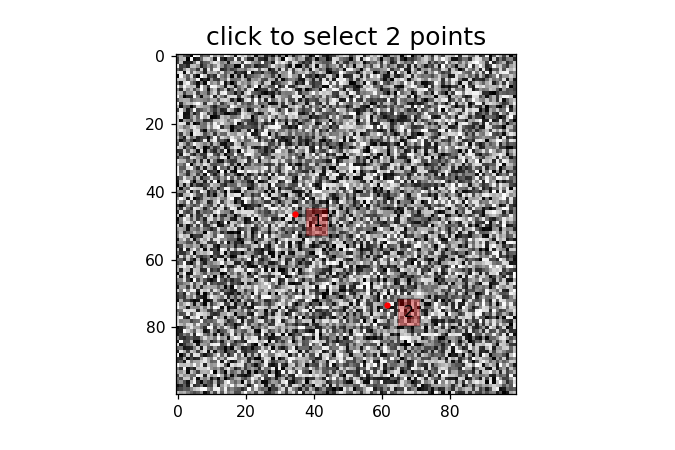

offset= 5.0


In [19]:
%matplotlib notebook
#### Demonstration of using the provided "selectpoints.py" function
#### First execute this cell

# display the image in the notebook 
# here we keep track of the image axis variable ax, which we 
# need to pass along to the select_k_points function
image = np.random.random((100,100))
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.imshow(image,cmap=plt.cm.gray)

#selectpoints will show the axis and wait for the specified # number of user clicks
k=2
spoints = select_k_points(ax,k)

In [20]:
#### Once the figure displays, you can click on two points

#### After you have finished clicking you can execute the cell to get the xy coordinates of your clicks
xp = spoints.xs
yp = spoints.ys

print(xp,yp)

[34.44757791930388, 61.58149992077554] [46.74061754014757, 73.41464255854345]


In [21]:
def segment(img, obj, bg, lambda_=1):
    g = maxflow.Graph[float]()
    h, w = img.shape[:2]
    nodeids = g.add_grid_nodes((h, w))
    
    def dist_in_color(a, b):
        # from: https://en.wikipedia.org/wiki/Color_difference
        # which basically is an Euclidean distance
        return np.linalg.norm(a - b)

    w_hori = np.zeros((h, w))
    w_vert = np.zeros((h, w))

    # Calculate the weights for the horizontal neighborhood
    for i in range(0, h):
        for j in range(1, w):
            w_hori[i, j] = dist_in_color(img[i, j], img[i, j-1])

    # Calculate the weights for the vertical neighborhood 
    for i in range(1, h):
        for j in range(0, w):
            w_vert[i, j] = dist_in_color(img[i, j], img[i-1, j])

    # --- Build neighbor links ---
    hori_struc=np.array([[0, 0, 0],
                                [1, 0, 0], 
                                [0, 0, 0]])
    vert_struc=np.array([[0, 1, 0],
                                [0, 0, 0],
                                [0, 0, 0]])
    g.add_grid_edges(nodeids, w_hori, structure=hori_struc, symmetric=True)
    g.add_grid_edges(nodeids, w_vert, structure=vert_struc, symmetric=True)
    
    # --- Build st edges ---
    obj_color = img[int(obj[0]), int(obj[1])]
    bg_color = img[int(bg[0]), int(bg[1])]
    obj_color_mat = np.tile(obj_color, (h, w, 1)) # replicate object's color for matrix subtraction
    bg_color_mat = np.tile(bg_color, (h, w, 1))
    
    obj_weights = np.zeros(img.shape[:2]) # weights to be added to the graph (for st edges)
    bg_weights = np.zeros(img.shape[:2])
    
    obj_weights += np.linalg.norm(img - obj_color_mat, axis=2) * lambda_
    bg_weights += np.linalg.norm(img - bg_color_mat, axis=2) * lambda_
    
    # add st edges to the graph
    g.add_grid_tedges(nodeids, obj_weights, bg_weights)
    
    # find the max flow
    g.maxflow()
    
    # return segmentation result
    sgm = g.get_grid_segments(nodeids)
    return sgm

## 3.2 Testing & Visualization

Show segmentations produced from the test images **segtest1.jpg** and 
**segtest2.jpg**. Also show results on at least one other image of your
choice. Use the {\tt plot} command to plot 'x's on the original image 
indicating where your seed points were for each example.  Comment on 
the successes and failures of this approach.


<IPython.core.display.Javascript object>


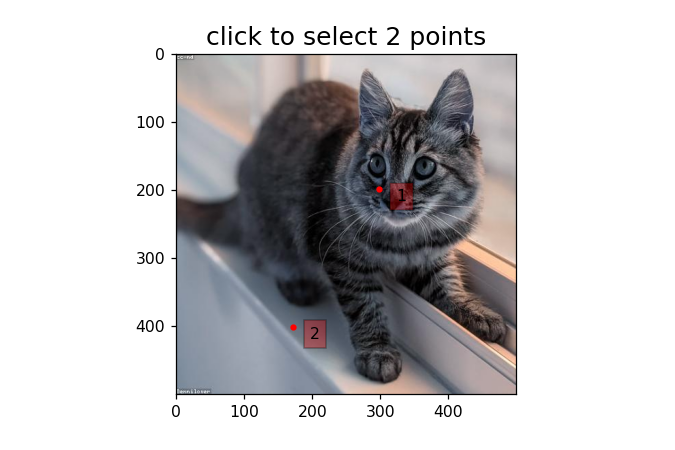

offset= 25.0


In [22]:
%matplotlib notebook
# select xp, yp for cat image
cat = cv2.imread("./cat.jpg")
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.imshow(cat)

#selectpoints will show the axis and wait for the specified # number of user clicks
k=2
spoints = select_k_points(ax,k)

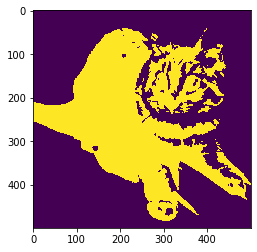

In [23]:
%matplotlib inline
# get xp, yp for cat
xp, yp = spoints.xs, spoints.ys
# plot segmentation result
plt.figure(figsize=(6, 4))
sgm = segment(min_max_scale(cat), xp, yp)
plt.imshow(sgm, interpolation="none")
plt.show()

<IPython.core.display.Javascript object>


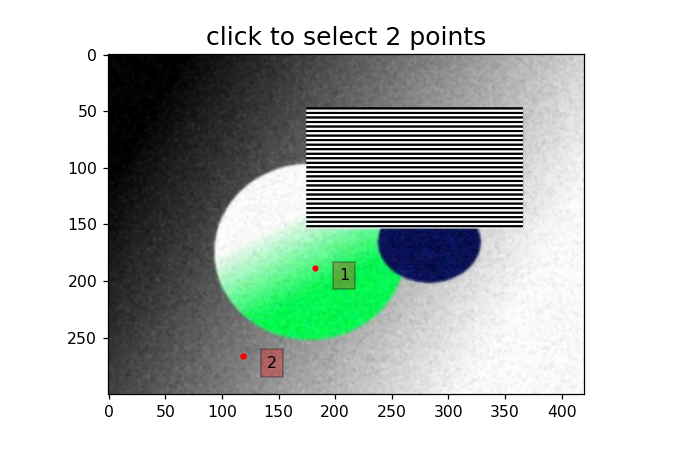

offset= 21.0


In [24]:
%matplotlib notebook
# select xp, yp for segtest 1
segtest1 = cv2.imread("./segtest1.jpg")
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.imshow(segtest1)

#selectpoints will show the axis and wait for the specified # number of user clicks
k=2
spoints = select_k_points(ax,k)

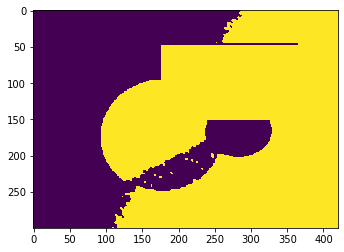

In [25]:
%matplotlib inline
# get xp, yp for segtest 1
xp, yp = spoints.xs, spoints.ys
# plot segmentation result
plt.figure(figsize=(6, 4))
sgm = segment(min_max_scale(segtest1), xp, yp)
plt.imshow(sgm, interpolation="none")
plt.show()

<IPython.core.display.Javascript object>


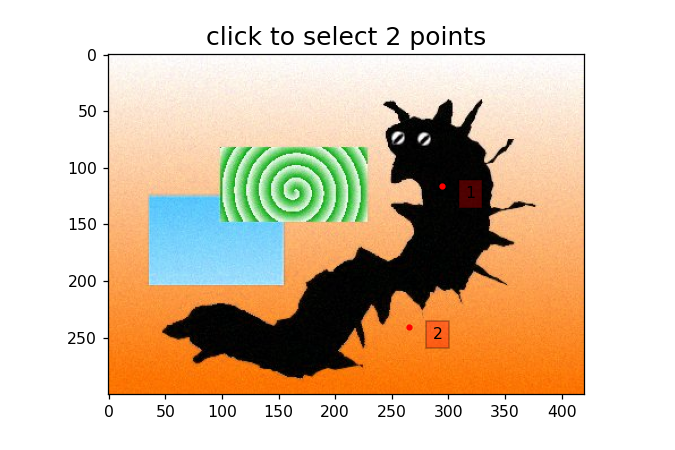

offset= 21.0


In [31]:
%matplotlib notebook
# select xp, yp for segtest 2
segtest2 = cv2.imread("./segtest2.jpg")
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.imshow(segtest2)

#selectpoints will show the axis and wait for the specified # number of user clicks
k=2
spoints = select_k_points(ax,k)

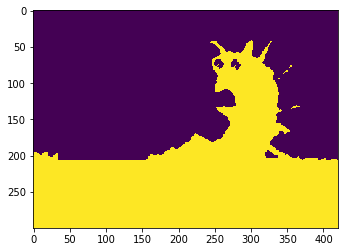

In [33]:
%matplotlib inline
# get xp, yp for segtest 2
xp, yp = spoints.xs, spoints.ys
# plot segmentation result
plt.figure(figsize=(6, 4))
sgm = segment(min_max_scale(segtest2), xp, yp, lambda_=1)
plt.imshow(sgm, interpolation="none")
plt.show()

Here we try different values of lambda and show the result (on segtest2 image) with a same xp, yp

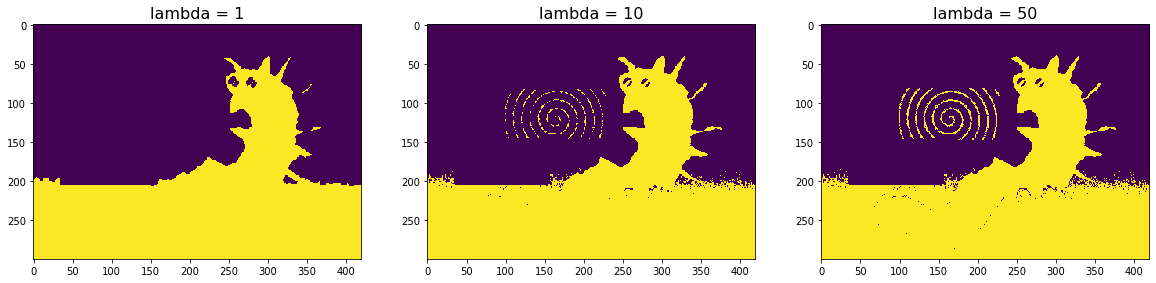

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sgm1 = segment(min_max_scale(segtest2), xp, yp)
sgm10 = segment(min_max_scale(segtest2), xp, yp, lambda_=10)
sgm50 = segment(min_max_scale(segtest2), xp, yp, lambda_=50)
ax[0].imshow(sgm1, interpolation="none")
ax[0].set_title("lambda = 1")
ax[1].imshow(sgm10, interpolation="none")
ax[1].set_title("lambda = 10")
ax[2].imshow(sgm50, interpolation="none")
ax[2].set_title("lambda = 50")
plt.show()

We can see that lambda does affect the segmentation result. In the first result of segtest2 (where lambda = 1), the square next to the object is not segmented. However, increasing the lambda gives st edges higher weights, and therefore we can see that the square is now successfully segmented by the min-cut algorithm.

Next we demonstrate some different values of xp and yp.

<IPython.core.display.Javascript object>


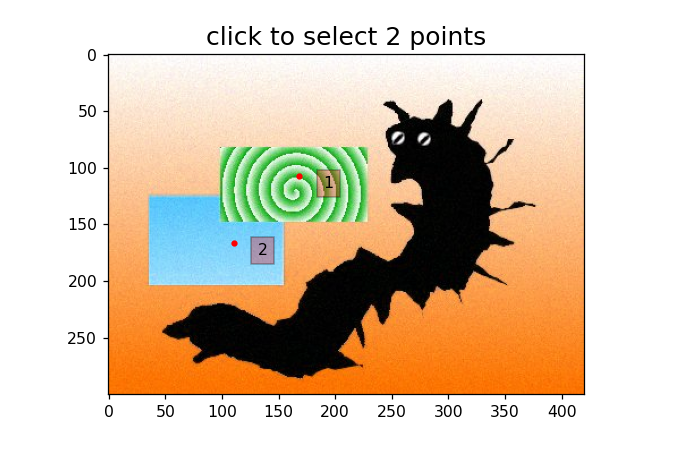

offset= 21.0


In [35]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.imshow(segtest2)

#selectpoints will show the axis and wait for the specified # number of user clicks
k=2
spoints = select_k_points(ax,k)

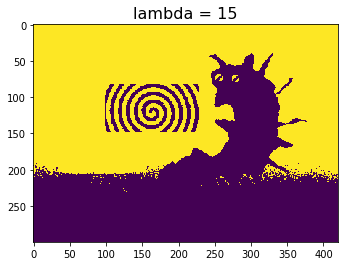

In [36]:
%matplotlib inline
# get xp, yp for segtest 2
xp, yp = spoints.xs, spoints.ys
# plot segmentation result
plt.figure(figsize=(6, 4))
sgm = segment(min_max_scale(segtest2), xp, yp, lambda_=15)
plt.imshow(sgm, interpolation="none")
plt.title("lambda = 15")
plt.show()

So a good selection of foreground background and a proper lambda will help us improve segmentation performance.

### Extra Credit:

Modify your model to use your texture or color feature code
developed in the first two questions in order to build foreground and
background models based on histograms.  You can either build a histogram of
quantized colors (use $k=20$) or a histogram of quantized filter responses
(textons) or both (by just concatenating the two histograms together).  For
each pixel, you should compute a histogram of the quantized colors/textons that
occur in a square window centered at that pixel.  You can then define the s/t
weights by comparing the histogram for that pixel with the foreground and
background models.  Keep the neighbor edge weights based on color differences
as before.

## 4. Project Proposal

Put together a short description of a proposed project for the class and include
below.  I will try to post some links to ideas and papers on the course
website but feel free to suggest something else which interests you.  You will
need to be careful to choose something that is interesting enough to impress
and intrigue your classmates (not too trivial), but also that you can
successfully implement in a few weeks time (not too big).

I want to apply segmentation algorithms (like MRF we used) to a real-world car driving video. It might be helpful to detect objects like pedestrians or bike riders on the road for self-driving cars since we only want to avoid hitting them while driving. Nowadays, people use DL models to solve these questions, but models can make a mistake in a noisy environment, like on rainy days. If we can quickly determine whether there are possible objects that we should avoid, we don't really need to decide whether or not it is a person or a road sign.